# PetroFit Demo: Petrosian Photometry on abell2744_hffpar

In [1]:
import os 

from multiprocessing import Pool, cpu_count

import numpy as np

from astropy.nddata import CCDData, Cutout2D
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy import units as u

from photutils import source_properties, SourceProperties
from photutils.segmentation import SourceCatalog 

In [2]:
from petrofit.segmentation import make_catalog, plot_segments
from petrofit.petrosian import Petrosian, PetrosianCorrection
from petrofit.photometry import get_source_position, get_source_elong, get_source_theta, source_photometry, flux_to_abmag, order_cat, radial_elliptical_aperture
from petrofit.utils import angular_to_pixel

In [3]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'
#plt.rcParams.update({'font.size': 17})

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def savefig(filename):
    plt.savefig("../plots/"+filename, dpi=70, bbox_inches = 'tight', pad_inches = 0.1)

In [4]:
import ipywidgets as widgets
from IPython.display import display

DISPLAY_STYLE = {'description_width': 'initial'}

# Define Paths

In [5]:
acs_filter_list = ['f435w', 'f606w', 'f814w']
wfc3_filter_list = ['f105w', 'f125w', 'f140w', 'f160w']
input_data_formatter_wfc =  "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch2/hlsp_frontier_hst_{}-60mas_abell2744-hffpar_{}_v1.0-epoch2_drz.fits"
input_data_formatter_acs =  "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_{}-60mas_abell2744-hffpar_{}_v1.0_drz.fits"


In [6]:
program_name = os.path.basename(input_data_formatter_wfc).replace("_{}","").replace('-','').replace('epoch2','')
program_name = os.path.splitext(program_name)[0]
program_name

'hlsp_frontier_hst60mas_abell2744hffpar_v1.0_drz'

In [7]:
data_paths = {}
for f in acs_filter_list:
    data_paths[f] = input_data_formatter_acs.format('acs', f)
    
for f in wfc3_filter_list:
    data_paths[f] = input_data_formatter_wfc.format('wfc3', f)
    
petrosian_cat_collection = {}

In [8]:
for f in acs_filter_list + wfc3_filter_list:
    print("{}: {}".format(f, data_paths[f]))

f435w: https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_acs-60mas_abell2744-hffpar_f435w_v1.0_drz.fits
f606w: https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_acs-60mas_abell2744-hffpar_f606w_v1.0_drz.fits
f814w: https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_acs-60mas_abell2744-hffpar_f814w_v1.0_drz.fits
f105w: https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-60mas_abell2744-hffpar_f105w_v1.0-epoch2_drz.fits
f125w: https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-60mas_abell2744-hffpar_f125w_v1.0-epoch2_drz.fits
f140w: https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-60mas_abell2744-hffpar_f140w_v1.0-epoch2_drz.fits
f160w: https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch

# User Input

We select the center of the cluster in this section and the size of the cutout that will be analyzed. We also specify the center and cutout size of a patch of the image that we will use to estimate the background noise stats.

In [9]:
show_plots = True

# Dark patch:
# A dark patch in the image to measure background stats
noise_cutout_center = (2360, 2010)
noise_cutout_size = 50

# Center of cluster:
cx, cy = [2700, 2700]
data_cutout_size = 2000

# Detection Image

Before we can analyze images of galaxies, we first need to make a catalog of their positions. To locate galaxies, we first select a band of interest and download the image:

In [10]:
detection_filter = 'f160w'
input_data_path = data_paths[detection_filter]
detection_data = CCDData.read(input_data_path, cache=True)

In [11]:
print(input_data_path)

https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-60mas_abell2744-hffpar_f160w_v1.0-epoch2_drz.fits


### Estimate detection data noise at dark area

The following cell makes a cutout of the noise image (cutout of dark patch we specified) and measure the mean, std and sigma values for later use.

1.6632017e-05 0.0025688917958177626 0.0068503781221807


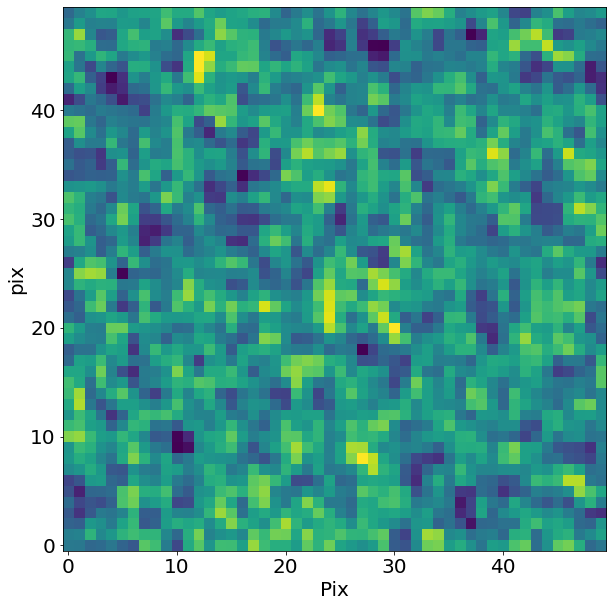

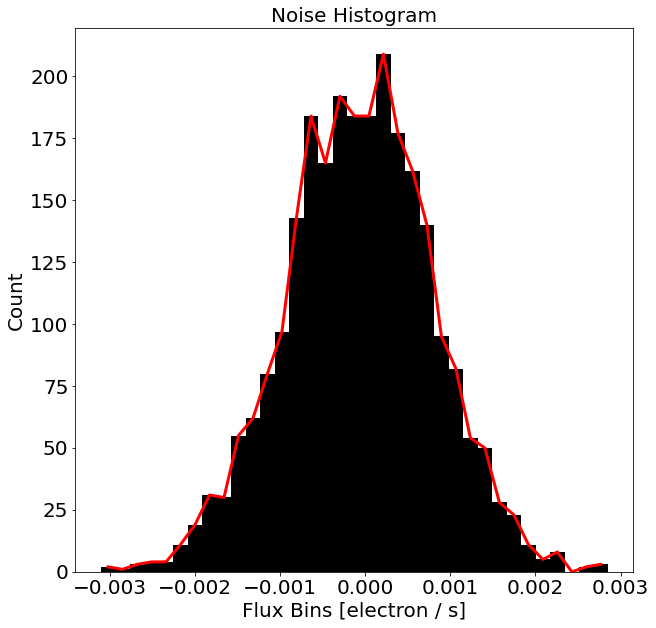

In [12]:


detection_noise_cutout = Cutout2D(detection_data, noise_cutout_center, noise_cutout_size)

detection_noise_mean = detection_noise_cutout.data.mean()
detection_noise_sigma = detection_noise_cutout.data.std()
detection_noise_3_sigma = detection_noise_sigma * 3.
detection_noise_8_sigma = detection_noise_sigma * 8.

print(detection_noise_mean, detection_noise_3_sigma, detection_noise_8_sigma)
    
if show_plots:
    plt.imshow(detection_noise_cutout.data, 
               vmax=detection_noise_mean+detection_noise_3_sigma, 
               vmin=detection_noise_mean-detection_noise_3_sigma)
    plt.xlabel('Pix')
    plt.ylabel('pix')
    plt.show()
    
    n, bins, patches = plt.hist(detection_noise_cutout.data.flatten(), bins=35, align='left', color='black')
    plt.plot(bins[:-1], n, c='r', linewidth=3)

    plt.xlabel('Flux Bins [{}]'.format(str(detection_data.unit)))
    plt.ylabel('Count')
    plt.title('Noise Histogram')
    plt.show()

### Cutout Detection Image

In this section we make a cutout of the cluster at the user specified center and size. We also compute some stats that will become useful in the detection stage. We also use the detection image std to set the `vmax` and `vmin` of the detection image plots.

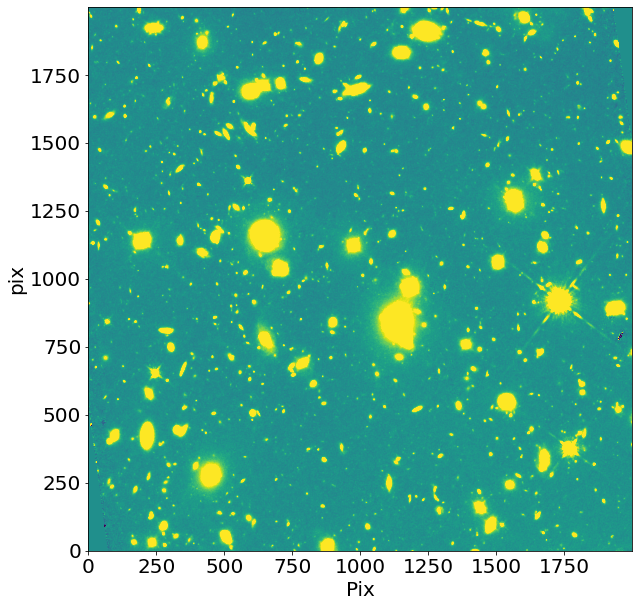

In [13]:
detection_image = Cutout2D(detection_data, (cx, cy), data_cutout_size, copy=True)

# Compute image stats
detection_image_min = detection_image.data.min()
detection_image_max = detection_image.data.max()
detection_image_mean = detection_image.data.mean()
detection_image_sigma = detection_image.data.std()
detection_image_3_sigma = detection_image_sigma * 3.
detection_image_8_sigma = detection_image_sigma * 8.

detection_image_clipped_mean, detection_image_clipped_median, detection_image_clipped_std = sigma_clipped_stats(detection_image.data, sigma=3.0)

# Subtract Noise
# detection_image.data  -= detection_image_clipped_mean
# detection_image.data = np.clip(detection_image.data, -detection_image_3_sigma, np.inf)

# Set min and max values for all plots
vmin = -10 * detection_image_clipped_std
vmax = +10 * detection_image_clipped_std

if show_plots:
    plt.imshow(detection_image.data, vmin=vmin, vmax=vmax)
    plt.xlabel('Pix')
    plt.ylabel('pix')
    plt.show()

#print(image_mean)

### Segmentation and Main Catalog

In this section we use PhotUtils to make a segmentation map and deblend the identified sources. Please note that `make_segments` and `deblend_segments` are wrappers for their respective PhotUtils functions that make it easy to pass arguments. 

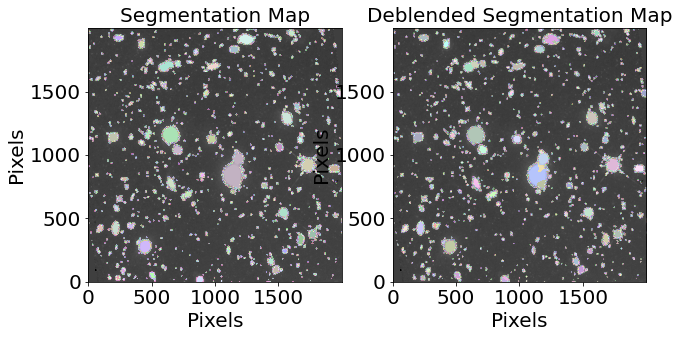

In [14]:
# Define detect threshold
threshold = detection_noise_8_sigma 

# Define smoothing kernel
kernel_size = 3 
fwhm = 3
npixels = 4**2


detection_cat, detection_segm, detection_segm_deblend = make_catalog(
    detection_image.data,
    threshold,
    deblend=True,
    kernel_size=kernel_size,
    fwhm=fwhm,
    npixels=npixels,
    contrast=1/100,
    plot=show_plots, vmax=vmax, vmin=vmin
)



In [15]:
detection_cat = detection_cat[order_cat(detection_cat)]
len(detection_cat)

754

# Measure Petrosian

We measure here the Petrosian radii of sources by analyzing their radial light profiles. To do this we select the max pixel to be equivalent to 15 arcsec and sample at every pixel up to the max pixel.

In [16]:
# Define Radii
# ------------
# Calculate galaxy size
galaxy_pixel_size = angular_to_pixel(15 * u.arcsec, wcs=detection_image.wcs) # convert to pixels

# Define max rad in pixels and number of apertures
max_pix = 500#int(round(galaxy_pixel_size))
n = int(max_pix)

# Create list of radii
r_list = [x * int(max_pix / n) for x in range(1, n+1)]
r_list = np.array(r_list)

print("galaxy_pixel_size = {:0.2f} pix".format(galaxy_pixel_size))
print("max_pix = {} pix".format(max_pix, n))
print("n = {}".format(max_pix, n))
print("len(r_list) = {}".format(len(r_list)))

galaxy_pixel_size = 250.00 pix
max_pix = 500 pix
n = 500
len(r_list) = 500


## Detection Photometry and Petrosian Calculation 

For each source in the detection catalog, measure the Petrosian properties. Before making the measurement, we measure the photometery of the objects by :
1. Estimate a good size for the cutout around the target source (`cutout_size`) using the size of the segmentation box.
2. Clip the radius array if it is larger than the cutout image (to save compute time).
3. Mask all sources that are not the target.
4. Make a cutout of the target.
5. To subtract the background around the source, we fit a 2D plane to the cutout pixels that are below the `sigma` parameter. We then turn the fitted 2D plane model into an image, which we subtract from the cutout. 
6.  We measure the photometry at each radius in the clipped radius list. The shape of the apertures is elliptical. The elongation and orientation of the ellipse are determined by the of the source in the segmentation output.
7. We then use the output of the photometry to construct a curve of growth and construct a  `Petrosian` object which can be used to infer Petrosian properties (radius, C2080 etc..)

In [17]:
pb = widgets.IntProgress(
    value=0,
    min=0,
    max=len(detection_cat),
    step=1,
    description='Loading:',
    bar_style='',
    orientation='horizontal',
    style=DISPLAY_STYLE,
)
display(pb)

petrosian_properties_rows = []

pc = PetrosianCorrection('../concentration_index_grid_f160w.yml')

for idx, obj in enumerate(detection_cat):
    pb.value = idx + 1
    pb.description = "{}: {}/{}".format(detection_filter, pb.value, len(detection_cat))
    
    bbox_x = obj.bbox.ixmax - obj.bbox.ixmin
    bbox_y = obj.bbox.iymax - obj.bbox.iymin
    bbox = int(max(bbox_x, bbox_y, np.sqrt(bbox_x**2+bbox_y**2))) + 1
    max_r = (bbox * 2) #// 2
    cutout_size = bbox * 2
    
    flux_arr, area_arr, error_arr = source_photometry(
        obj, detection_image.data, 
        detection_segm_deblend, r_list[:max_r], 
        plot=False, sigma=1, sigma_type='clip',
        vmax=vmax/10, vmin=0, 
        bkg_sub=True, mask_background=False,
        cutout_size=cutout_size, #method='center'
    )
    plt.show()
    
    p = Petrosian(r_list[:max_r], area_arr[:max_r], flux_arr[:max_r],)
    
    
    if p.fraction_flux_to_r(0.5) > 10:
        p.epsilon = pc.estimate_epsilon(p.r_half_light, p.c2080)
    

        if p.r_total_flux > p.r_list.max():
            p.epsilon = ((p.r_list.max()-1))/p.r_petrosian
            
        
    petrosian_properties_rows.append(p)
    
    if False:
        p.plot(plot_r=False, plot_normalized_flux=False)
        plt.show()


IntProgress(value=0, description='Loading:', max=754, style=ProgressStyle(description_width='initial'))

In [18]:
from petrofit.utils import pixel_to_angular
pixel_to_angular(10, detection_image.wcs).value

0.6000007677575858

# Photometry

In this section we preform photometry in each WCS and ACS filter. We place the contents of this cell in a function because we want to take advantage of multiprocessing to speed things up. We follow the same steps as above, but use the segmentation map and catalog from the detection image in this step. In this step, we use two apertures with radii equal to the Petrosian `r_half_light` and `r_total_flux` (same shape as before).

In [19]:
def photometry_process_image(current_filter, show_plots=False):
    print(current_filter + " ")

    input_data_path = data_paths[current_filter]
    output_path = "{}_petrosian_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])
    
    # Load data and vitals
    # ---------------------
    data = CCDData.read(input_data_path, cache=True)
    rms_data = None#fits.getdata(input_data_path.replace('drz', 'rms'), cache=True)
    
    if show_plots:
        plt.imshow(data, vmin=0, vmax=data.data.mean()*10)
        plt.show()
        
    # Estimate data noise at dark area
    # --------------------------------
    noise_cutout = Cutout2D(data, noise_cutout_center, noise_cutout_size)

    noise_mean = noise_cutout.data.mean()
    noise_sigma = noise_cutout.data.std()
    noise_3_sigma = noise_sigma * 3.
    noise_8_sigma = noise_sigma * 8.

    if show_plots:
        plt.imshow(noise_cutout.data, vmax=noise_mean+noise_3_sigma, vmin=noise_mean-noise_3_sigma)
        plt.show()
    
        n, bins, patches = plt.hist(noise_cutout.data.flatten(), bins=35, align='left', color='black')
        plt.plot(bins[:-1], n, c='r', linewidth=3)

        plt.xlabel('Flux Bins [{}]'.format(str(data.unit)))
        plt.ylabel('Count')
        plt.title('Noise Histogram')
        plt.show()
    
    # Cutout Image
    # -------------
    image = Cutout2D(data, (cx, cy), data_cutout_size, copy=True)
    rms_image = None #Cutout2D(rms_data, (cx, cy), data_cutout_size, copy=True)

    # Compute image stats
    image_min = image.data.min()
    image_max = image.data.max()
    image_mean = image.data.mean()
    image_sigma = image.data.std()
    image_3_sigma = image_sigma * 3.
    image_8_sigma = image_sigma * 8.

    image_clipped_mean, image_clipped_median, image_clipped_std = sigma_clipped_stats(image.data, sigma=3.0)

    # Subtract Noise
    #image.data  -= noise_mean

    # Set min and max values for all plots
    vmin = -10 * image_clipped_std
    vmax = +10 * image_clipped_std
    
    if show_plots:
        plt.imshow(image.data, vmin=vmin, vmax=vmax)
        plt.show()

    # Segmentation
    # ------------
    
    # Make segmentation map
    segm = detection_cat

    # Deblend segmentation map
    segm_deblend = detection_segm_deblend

    # Remove border sources
    #segm_deblend.remove_border_labels(1)

    # Make catalog
    cat = detection_cat

    # Display source properties
    #print("Num of Targets:", len(cat))

    # Plot segments
    if show_plots:
        plot_segments(segm_deblend, image.data, vmin=vmin, vmax=vmax)
        plt.show()
        
    # Photomerty
    # ----------
    pb = widgets.IntProgress(
        value=0,
        min=0,
        max=len(cat),
        step=1,
        description='Loading:',
        bar_style='',
        orientation='horizontal',
        style=DISPLAY_STYLE,
    )
    display(pb)

    # Output lists
    photometry_rows = []
    error_rows = []
    mag_rows = []
    mag_error_rows = []
    
    # For each object in the catalog preform photometry 
    # at Petrosian `r_half_light` and `r_total_flux`.
    for idx, obj in enumerate(cat):
        pb.value = idx + 1
        pb.description = "{}: {}/{}".format(current_filter, pb.value, len(cat))
        
        # Get Petrosian properties
        petrosian_properties = petrosian_properties_rows[idx]
        
        # Load radii 
        r_total_flux = petrosian_properties.r_total_flux
        r_half_light = petrosian_properties.r_half_light
        if np.any(np.isnan(np.array([r_half_light, r_total_flux]))) or np.any(np.array([r_half_light, r_total_flux]) <=0):
            nan_values = np.array([np.nan, np.nan])
            photometry_rows.append(nan_values)
            error_rows.append(nan_values)
            mag_rows.append(nan_values)
            mag_error_rows.append(nan_values)
            continue

        # Estimate cutout of target object 
        bbox = max(obj.bbox.ixmax - obj.bbox.ixmin, obj.bbox.iymax - obj.bbox.iymin)
        # cutout_size = max(obj.bbox.ixmax - obj.bbox.ixmin, obj.bbox.iymax - obj.bbox.iymin)
        cutout_size = r_total_flux * 2.5
        
        # Get object photometry
        flux_arr, area_arr, error_arr = source_photometry(
            obj, image.data, segm_deblend, 
            r_list=[r_half_light, r_total_flux],
            error=None, #rms_image.data,
            cutout_size=cutout_size,
            bkg_sub=True, sigma=1, mask_background=False, 
            plot=show_plots, vmax=vmax, vmin=vmin, 
        )
        
        
        flux_arr[np.where(flux_arr <= 0)] = np.nan
        
        error_arr = np.sqrt(flux_arr)
        # Add photometry results to output lists
        photometry_rows.append(flux_arr)
        error_rows.append(error_arr)
        mag_rows.append(flux_to_abmag(flux_arr, data.header))
        mag_error_rows.append(flux_to_abmag(error_arr, data.header))

    # Return output lists
    return photometry_rows, error_rows, mag_rows, mag_error_rows

In [20]:
# Start multiprocessing photometry (a core per filter)
if __name__ == '__main__':
    with Pool(processes=cpu_count()) as pool: 
        print("Starting MP")
        try:
            photometry_results = pool.map(photometry_process_image, acs_filter_list + wfc3_filter_list)
        except Exception as e:
            pool.close()
            raise e 
            
    print("Done")

f435w f606w f125w f160w f105w f140w f814w 






Starting MP


IntProgress(value=0, description='Loading:', max=754, style=ProgressStyle(description_width='initial'))

IntProgress(value=0, description='Loading:', max=754, style=ProgressStyle(description_width='initial'))

IntProgress(value=0, description='Loading:', max=754, style=ProgressStyle(description_width='initial'))

IntProgress(value=0, description='Loading:', max=754, style=ProgressStyle(description_width='initial'))

IntProgress(value=0, description='Loading:', max=754, style=ProgressStyle(description_width='initial'))

IntProgress(value=0, description='Loading:', max=754, style=ProgressStyle(description_width='initial'))

IntProgress(value=0, description='Loading:', max=754, style=ProgressStyle(description_width='initial'))

Done


# Combine Catalogs

In this section we combine the photometry results and add them to the detection catalog. During the combination step, we plot the total mag verses the difference between the total mag and the “log double” of the half-light mag. A difference close to 0 shows that the photometry and radii measurements were good.

In [21]:
wcs = detection_image.wcs
#wcs.sip = None

Adding Petrosian values...


/mnt/c/Users/robel/project/repo/petrofit/petrofit/petrosian.py:337: RuntimeWarning: invalid value encountered in double_scalars
  return r1, r2, 5 * np.log10(r2 / r1)
/mnt/c/Users/robel/project/repo/petrofit/petrofit/petrosian.py:337: RuntimeWarning: divide by zero encountered in double_scalars
  return r1, r2, 5 * np.log10(r2 / r1)


Adding photometry values...
f435w
f606w
f814w
f105w
f125w
f140w
f160w


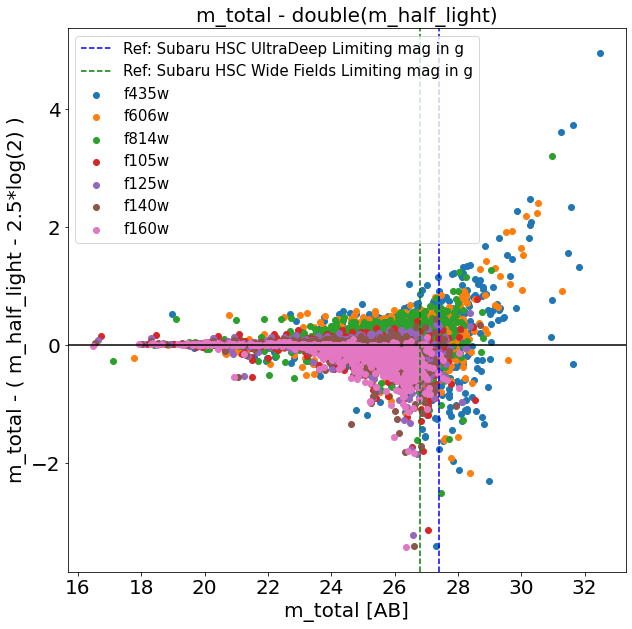

In [22]:
columns = []
column_names = []

r_petrosian_list = []
r_half_light_list = []
r_half_light_arcsec_list = []
r_total_flux_list = []
r_total_flux_arcsec_list = []
r20_list = []
r80_list = []
c2080_list = []

print("Adding Petrosian values...")
for p in petrosian_properties_rows:
    r_petrosian_list.append(p.r_petrosian)
    r_half_light_list.append(p.r_half_light)
    r_half_light_arcsec_list.append(p.r_half_light_arcsec(wcs))
    r_total_flux_list.append(p.r_total_flux)
    r_total_flux_arcsec_list.append(p.r_total_flux_arcsec(wcs))
    r20_list.append(p.concentration_index()[0])
    r80_list.append(p.concentration_index()[1])
    c2080_list.append(p.concentration_index()[2])    
    
columns.append(np.array(r_petrosian_list))
column_names.append('r_petrosian')

columns.append(np.array(r_half_light_list))
column_names.append('r_half_light')

columns.append(np.array(r_half_light_arcsec_list))
column_names.append('r_half_light_arcsec')

columns.append(np.array(r_total_flux_list))
column_names.append('r_total_flux')

columns.append(np.array(r_total_flux_arcsec_list))
column_names.append('r_total_flux_arcsec')

columns.append(np.array(r20_list))
column_names.append('r20')

columns.append(np.array(r80_list))
column_names.append('r80')

columns.append(np.array(c2080_list))
column_names.append('c2080')

print("Adding photometry values...")
for idx,  filt in  enumerate(acs_filter_list + wfc3_filter_list):
    print(filt)
    f1, f2 = np.transpose(np.array(photometry_results[idx][0]))
    err1, err2 = np.transpose(np.array(photometry_results[idx][1]))
    half_light_mags, total_mags = np.transpose(np.array(photometry_results[idx][2]))
    merr1, merr2 = np.transpose(np.array(photometry_results[idx][3]))
    
    # Plot Mag diff 
    double_hl = half_light_mags - 2.5*np.log10(2) # Double the half light mag
    total_double_hl_diff = total_mags - double_hl
    plt.scatter(total_mags, total_double_hl_diff, label=filt)
   
    columns.append(f1)
    column_names.append('f_half_light_{}'.format(filt))
    
    columns.append(err1)
    column_names.append('f_half_light_err_{}'.format(filt))
    
    columns.append(f2)
    column_names.append('f_total_{}'.format(filt))

    columns.append(err2)
    column_names.append('f_total_err_{}'.format(filt))
    
    columns.append(half_light_mags)
    column_names.append('m_half_light_{}'.format(filt))
    
    columns.append(merr1)
    column_names.append('m_half_light_err_{}'.format(filt))
    
    columns.append(total_mags)
    column_names.append('m_total_{}'.format(filt))
    
    columns.append(merr2)
    column_names.append('m_total_err_{}'.format(filt))

# https://prc.nao.ac.jp/citizen-science/hscv/hscdata_e.html
plt.axvline(27.4, c='blue', label="Ref: Subaru HSC UltraDeep Limiting mag in g", linestyle="--")
plt.axvline(26.8, c='green', label="Ref: Subaru HSC Wide Fields Limiting mag in g", linestyle="--")

plt.axhline(0, c='black')

plt.title('m_total - double(m_half_light)')
plt.xlabel("m_total [AB]")
plt.ylabel("m_total - ( m_half_light - 2.5*log(2) )")

plt.legend()

In [23]:
petrosian_cat = detection_cat.to_table().copy()

xindex, yindex = detection_cat.maxval_xindex, detection_cat.maxval_yindex
ra, dec = detection_image.wcs.all_pix2world(xindex, yindex, 0)

petrosian_cat.add_column(ra*u.deg, index=1, name='ra')
petrosian_cat.add_column(dec*u.deg, index=2, name='dec')

petrosian_cat.add_column(xindex, index=3, name='maxval_xindex')
petrosian_cat.add_column(yindex, index=4, name='maxval_yindex')

for c, cn in zip(columns, column_names):
    petrosian_cat.add_column(c, name=cn)
petrosian_cat[:10]

label,ra,dec,maxval_xindex,maxval_yindex,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr,r_petrosian,r_half_light,r_half_light_arcsec,r_total_flux,r_total_flux_arcsec,r20,r80,c2080,f_half_light_f435w,f_half_light_err_f435w,f_total_f435w,f_total_err_f435w,m_half_light_f435w,m_half_light_err_f435w,m_total_f435w,m_total_err_f435w,f_half_light_f606w,f_half_light_err_f606w,f_total_f606w,f_total_err_f606w,m_half_light_f606w,m_half_light_err_f606w,m_total_f606w,m_total_err_f606w,f_half_light_f814w,f_half_light_err_f814w,f_total_f814w,f_total_err_f814w,m_half_light_f814w,m_half_light_err_f814w,m_total_f814w,m_total_err_f814w,f_half_light_f105w,f_half_light_err_f105w,f_total_f105w,f_total_err_f105w,m_half_light_f105w,m_half_light_err_f105w,m_total_f105w,m_total_err_f105w,f_half_light_f125w,f_half_light_err_f125w,f_total_f125w,f_total_err_f125w,m_half_light_f125w,m_half_light_err_f125w,m_total_f125w,m_total_err_f125w,f_half_light_f140w,f_half_light_err_f140w,f_total_f140w,f_total_err_f140w,m_half_light_f140w,m_half_light_err_f140w,m_total_f140w,m_total_err_f140w,f_half_light_f160w,f_half_light_err_f160w,f_total_f160w,f_total_err_f160w,m_half_light_f160w,m_half_light_err_f160w,m_total_f160w,m_total_err_f160w
,deg,deg,,,,,,,,,,pix2,pix,pix,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,int64,int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float32,float32,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
681,3.4706670766046512,-30.384333303013985,1137,844,1136.2938510316214,843.6289815457819,None,1055,1246,745,940,19465.0,25.136800373130093,22.891578734881442,11.78184529144634,0.41311273048174696,0.0051549533,5.4722714,0.0,1083.5723,nan,1151.0303683543932,nan,54.41088217643529,19.90398079615923,1.1942403759127784,108.82176435287057,6.5293142160457425,6.00120024004801,49.00980196039208,4.560224148224351,5.544728,2.354724612348544,13.546803,3.6805981850780722,23.805785858691856,24.73563616672699,22.83589443660309,24.25069045568261,98.184768,9.908822735320276,204.563609,14.30257350968699,21.513214241947466,24.003269389783902,20.716253594876182,23.604789066248262,189.772512,13.77579442355322,374.164527,19.343332882417137,20.25103917044482,23.09883080337727,19.51396590770499,22.73029417200735,420.678495,20.510448434883134,826.653317,28.751579382705224,19.708942089628625,22.98887997905103,18.97550933667494,22.622163602574187,534.392882,23.116939287025,1036.778199,32.19904034284252,19.41056546176931,22.820391292763684,18.691002482673117,22.46060980321559,764.945024,27.657639523285425,1479.890483,38.46934471757999,19.243241216713052,22.847778996551504,18.526742833153634,22.489529804771795,550.07701,23.45372060036531,1063.552821,32.612157564319475,19.095168468203788,22.520697836155264,18.37932954444036,22.16277837427355
338,3.4800564241059675,-30.379083165219495,651,1159,651.0186431074359,1157.6804867403675,None,584,725,1078,1234,14973.0,17.659943389448085,16.839009611914207,-88.93778543859196,0.3013475833627203,0.005557742,4.610207,0.0,1665.971,nan,1605.2591379907417,nan,36.216843368673736,16.36967393478696,0.9821816928813516,71.86775042513841,4.312070543209361,7.039807961592318,30.70374074814963,3.1981523907854594,119.851879,10.94768829479539,248.383346,15.760182295900005,20.468874356874

# Save Final Catalog

In [24]:
final_catalog_output_path = "{}_petrosian_catalog.csv".format(program_name)
print(final_catalog_output_path)

petrosian_cat.write(final_catalog_output_path, overwrite=True)

print("Done")

hlsp_frontier_hst60mas_abell2744hffpar_v1.0_drz_petrosian_catalog.csv
Done


In [25]:
filter_list = acs_filter_list + wfc3_filter_list
filter_list

['f435w', 'f606w', 'f814w', 'f105w', 'f125w', 'f140w', 'f160w']

In [26]:
robel_catalog = petrosian_cat

robel_filters = ["m_total_{}".format(robel_filter) for robel_filter in filter_list[:]] 

In [27]:
# AstroDeep
astrodeep_catalog_path = "http://astrodeep.u-strasbg.fr/ff/data/catalogues/A2744PAR.xml"
astrodeep_catalog_name = "AstroDeep"

astrodeep_ra_kwrd = "RA"
astrodeep_dec_kwrd = "DEC"
astrodeep_z_kwrd = "ZBEST"
astrodeep_quality_kwrd = "ZSPECFLAG"

raw_astrodeep_catalog = Table.read(astrodeep_catalog_path)
print("{}: {}".format(astrodeep_catalog_name, len(raw_astrodeep_catalog)))

AstroDeep: 3411


In [28]:
astrodeep_catalog = raw_astrodeep_catalog

In [29]:
robel_ra, robel_dec = np.array(robel_catalog['ra']), np.array(robel_catalog['dec'])
astrodeep_ra, astrodeep_dec =  np.array(astrodeep_catalog[astrodeep_ra_kwrd]), np.array(astrodeep_catalog[astrodeep_dec_kwrd])


In [30]:
from petrofit.utils import plot_target, match_catalogs


In [31]:
idx, sep2d, sep3d = match_catalogs(
    robel_ra, robel_dec,
    astrodeep_ra, astrodeep_dec,
    
)

arcsec_cutoff = 0.5

prox_mask = sep2d.to('arcsec').value  < arcsec_cutoff

nan_mask = np.array([not np.any(np.isnan(np.array(list(i)))) for i in robel_catalog[robel_filters][prox_mask]])

num_matches = np.where(sep2d.to('arcsec').value  < arcsec_cutoff)[0].shape[0]
num_missing = len(astrodeep_catalog) - num_matches

print("Num Ra-Dec matchs: {}".format(num_matches))
print("Num Ra-Dec missing: {}".format(num_missing))
print("Fraction of matchs: ", num_matches / (num_matches + num_missing))

Num Ra-Dec matchs: 739
Num Ra-Dec missing: 2672
Fraction of matchs:  0.21665200820873645


In [32]:
len(prox_mask), len(robel_ra)

(754, 754)

In [33]:
matched_catalog = astrodeep_catalog[idx][prox_mask]
matched_catalog

ID,RA,DEC,MAG_B435,MAG_V606,MAG_I814,MAG_Y105,MAG_J125,MAG_JH140,MAG_H160,MAG_Ks,MAG_IRAC1,MAG_IRAC2,MAGERR_B435,MAGERR_V606,MAGERR_I814,MAGERR_Y105,MAGERR_J125,MAGERR_JH140,MAGERR_H160,MAGERR_Ks,MAGERR_IRAC1,MAGERR_IRAC2,ZBEST,ZBEST_SIQR,MAGNIF,ZSPECFLAG,MSTAR,SFR,RELFLAG
,deg,deg,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,1E9solMass,Msun / yr,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,int16
727,3.470681,-30.384335,23.0879,20.8599,19.6605,19.1306,18.8385,18.6712,18.5209,18.051,18.543,18.8765,0.02393,0.003007,0.0009751,0.0005015,0.0005863,0.0005016,0.0003,0.0005415,0.01787,0.01313,0.49989,0.0,1.04708971164,1,199.3,0.1707,1
908,3.480059,-30.379105,19.6808,18.8708,18.434,18.2308,18.0958,18.0282,17.9612,17.7506,18.4613,18.7953,0.001335,0.0006377,0.0003937,0.0002384,0.0003203,0.0002986,0.0002,0.0004383,0.01299,0.009212,0.23515,0.095,1.0,0,23.78,12.55,1
732,3.459159,-30.383099,18.8982,17.7294,17.0425,16.6903,16.5745,16.4972,16.4209,16.5251,17.5684,18.049,0.0007246,0.001274,0.0004067,8.782e-05,0.0001313,0.0001214,0.0001,4.24e-05,0.02867,0.02273,0.05,0.0105,1.0,0,17.85,0.0,1
101,3.483912,-30.393764,24.7562,23.0274,21.1239,20.1765,19.8282,19.623,19.4512,18.7749,18.6224,19.0186,0.1059,0.01943,0.003463,0.001039,0.00114,0.0009346,0.0006,0.0009275,0.0196,0.01513,0.845,0.059,1.25886152624,0,297.9,0.8868,1
1118,3.462345,-30.376942,22.2577,20.376,19.4706,19.0176,18.7521,18.6125,18.4864,17.9482,18.8283,19.0425,0.007947,0.001533,0.0006934,0.0003615,0.0004428,0.0004013,0.0002,0.0002748,0.02395,0.01734,0.312254,0.0,1.00197419497,1,76.88,0.5713,1
823,3.46974,-30.382212,23.5856,21.4542,20.2447,19.7214,19.4304,19.262,19.1119,18.5778,19.0656,19.3957,0.02353,0.003325,0.001118,0.0005622,0.0006663,0.0005754,0.0003,0.0005122,0.02605,0.01962,0.471,0.0495,1.04199919648,0,103.9,0.2037,1
1875,3.46859,-30.366545,21.0914,20.3981,20.0555,19.9044,19.8279,19.7855,19.7342,19.7118,20.4761,20.885,0.002673,0.001372,0.0009258,0.0006462,0.0008978,0.0008627,0.0006,0.002926,0.02231,0.02053,0.173,0.0375,1.0,0,2.486,1.107,1
281,3.488439,-30.391338,21.8931,20.6468,20.0268,19.7194,19.5104,19.4119,19.3144,18.9072,19.7118,19.8297,0.005608,0.001849,0.001004,0.0005982,0.0007498,0.0006766,0.0005,0.001408,0.01464,0.0106,0.304,0.0075,1.0,0,12.17,9.035,1


(-5.0, 5.0)

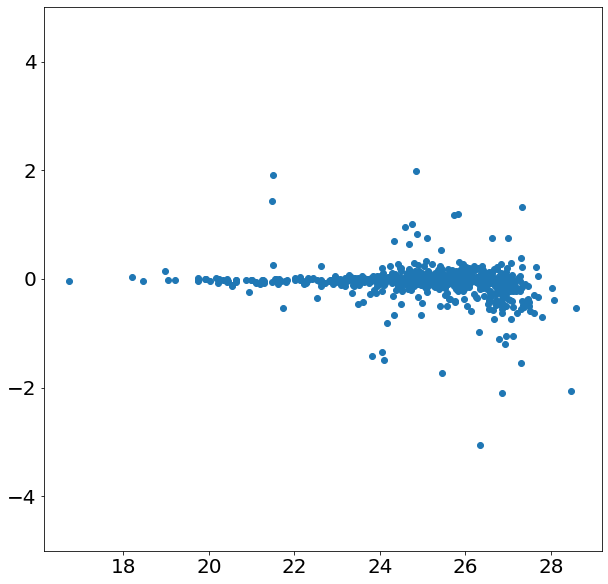

In [34]:
plt.scatter(robel_catalog['m_total_f105w'][prox_mask], matched_catalog['MAG_Y105']-robel_catalog['m_total_f105w'][prox_mask])
plt.ylim(-5,5)


In [35]:
astrodeep_filter_list = [
    'MAG_B435',
    'MAG_V606',
    'MAG_I814',
    'MAG_Y105',
    'MAG_J125',
    'MAG_JH140',
    'MAG_H160',
    #'MAG_IRAC1',
    #'MAG_IRAC2'

]

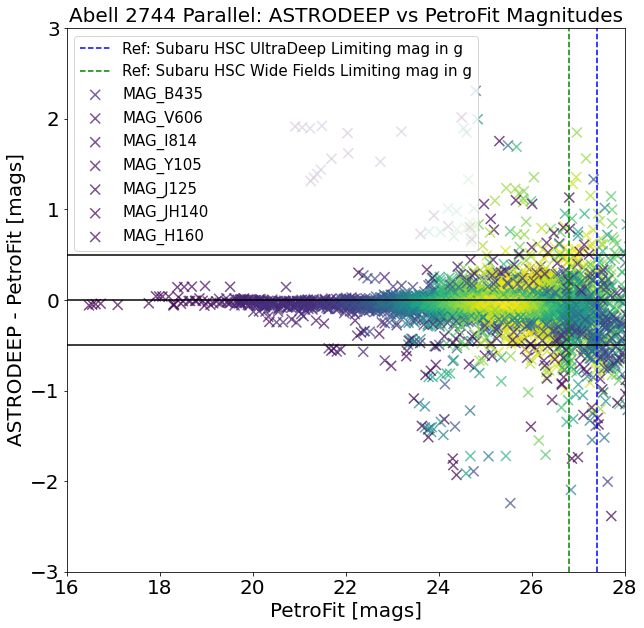

In [36]:
from scipy.stats import gaussian_kde





for robel_filter, astrodeep_filter in list(zip(filter_list, astrodeep_filter_list)):
    robel_filter = "m_total_{}".format(robel_filter)
    
    x = robel_catalog[robel_filter][prox_mask][nan_mask]
    y = matched_catalog[astrodeep_filter][nan_mask]-robel_catalog[robel_filter][prox_mask][nan_mask]
    
    mask = ~ (np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    plt.scatter(
        x, y, c=z, s=100,
        label=str(astrodeep_filter), alpha=0.7, marker='x', 
    )
    
plt.axvline(27.4, c='blue', label="Ref: Subaru HSC UltraDeep Limiting mag in g", linestyle="--")
plt.axvline(26.8, c='green', label="Ref: Subaru HSC Wide Fields Limiting mag in g", linestyle="--")

plt.ylim(-3,3)
plt.xlim(16,28)

plt.title('Abell 2744 Parallel: ASTRODEEP vs PetroFit Magnitudes')
plt.xlabel('PetroFit [mags]')
plt.ylabel('ASTRODEEP - PetroFit [mags]')

plt.axhline(0.5, c='black',)
plt.axhline(0, c='black',)
plt.axhline(-0.5, c='black',)

plt.legend()

plt.show()


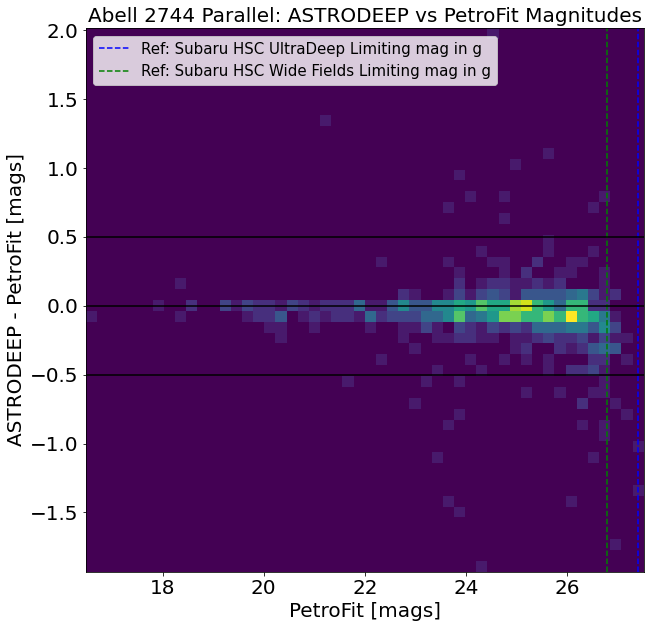

In [37]:
from scipy.stats import gaussian_kde





for robel_filter, astrodeep_filter in list(zip(filter_list, astrodeep_filter_list)):
    robel_filter = "m_total_{}".format(robel_filter)
    
    x = robel_catalog[robel_filter][prox_mask][nan_mask]
    y = matched_catalog[astrodeep_filter][nan_mask]-robel_catalog[robel_filter][prox_mask][nan_mask]
    
#     mask = ~ (np.isnan(x) | np.isnan(y))
#     x = x[mask]
#     y = y[mask]
    
#     xy = np.vstack([x,y])
#     z = gaussian_kde(xy)(xy)
    
    plt.hist2d(
        x, y, (50,50), cmax=15
    )
    

    
plt.axvline(27.4, c='blue', label="Ref: Subaru HSC UltraDeep Limiting mag in g", linestyle="--")
plt.axvline(26.8, c='green', label="Ref: Subaru HSC Wide Fields Limiting mag in g", linestyle="--")

# plt.ylim(-3,3)
# plt.xlim(16,28)

plt.title('Abell 2744 Parallel: ASTRODEEP vs PetroFit Magnitudes')
plt.xlabel('PetroFit [mags]')
plt.ylabel('ASTRODEEP - PetroFit [mags]')

plt.axhline(0.5, c='black',)
plt.axhline(0, c='black',)
plt.axhline(-0.5, c='black',)

plt.legend()

plt.show()


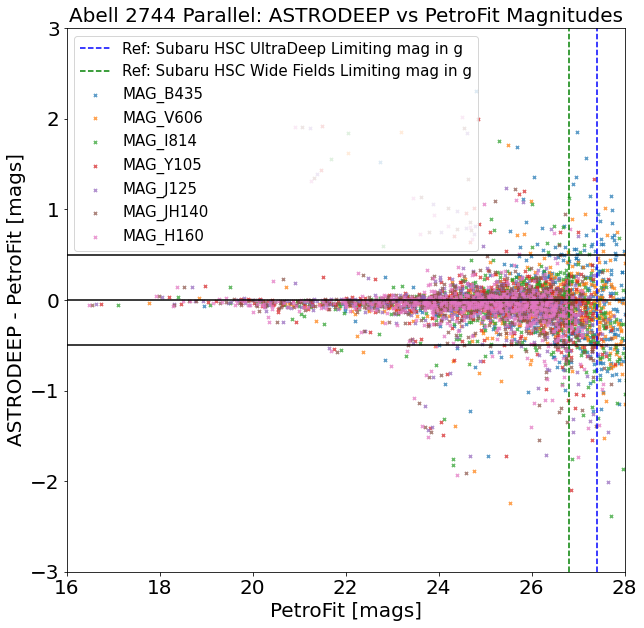

In [38]:
from scipy.stats import gaussian_kde





for robel_filter, astrodeep_filter in list(zip(filter_list, astrodeep_filter_list)):
    robel_filter = "m_total_{}".format(robel_filter)
    
    x = robel_catalog[robel_filter][prox_mask]
    y = matched_catalog[astrodeep_filter]-robel_catalog[robel_filter][prox_mask]
    
    mask = ~ (np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    plt.scatter(
        x, y, s=10,
        label=str(astrodeep_filter), alpha=0.7, marker='x', 
    )
    
plt.axvline(27.4, c='blue', label="Ref: Subaru HSC UltraDeep Limiting mag in g", linestyle="--")
plt.axvline(26.8, c='green', label="Ref: Subaru HSC Wide Fields Limiting mag in g", linestyle="--")

plt.ylim(-3,3)
plt.xlim(16,28)

plt.title('Abell 2744 Parallel: ASTRODEEP vs PetroFit Magnitudes')
plt.xlabel('PetroFit [mags]')
plt.ylabel('ASTRODEEP - PetroFit [mags]')

plt.axhline(0.5, c='black',)
plt.axhline(0, c='black',)
plt.axhline(-0.5, c='black')

plt.legend()

plt.show()


In [39]:
from petrofit.photometry import plot_apertures

In [40]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


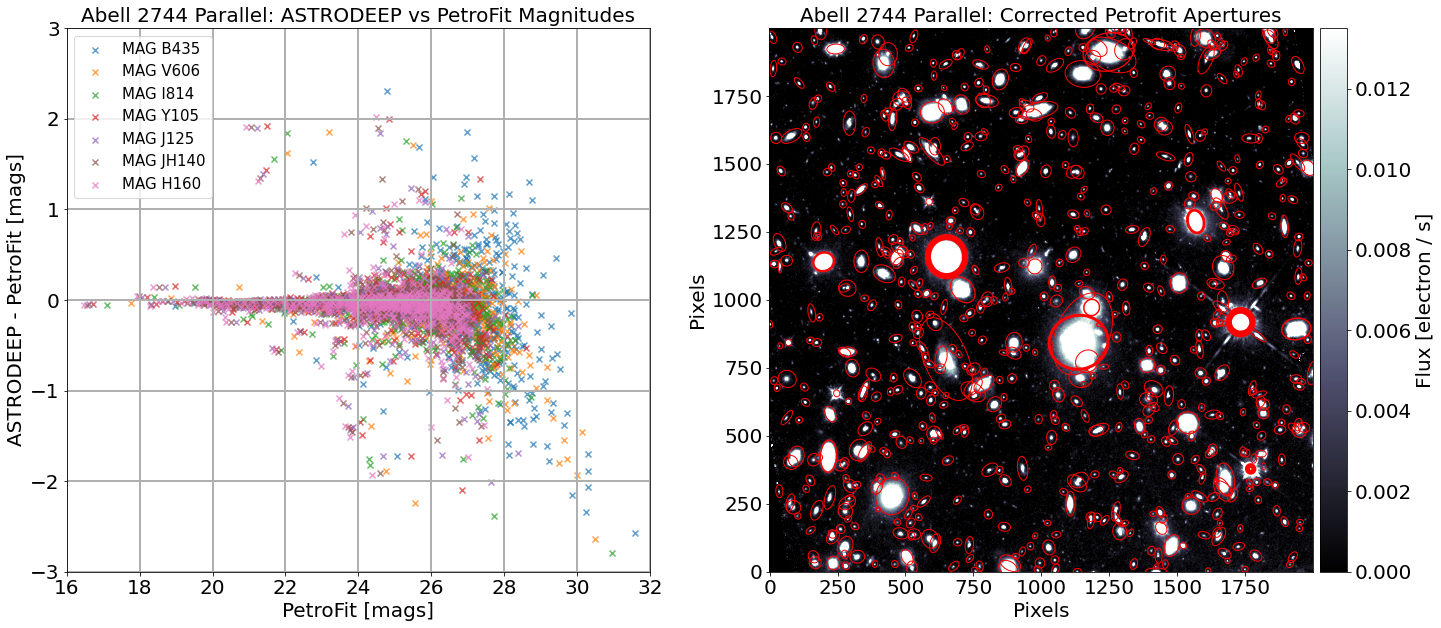

In [41]:
figsize = [10*2.3, 10*1]
fig, ax = plt.subplots(1, 2, figsize=figsize)

plt.sca(ax[0])

#plt.axhline(0, c='black', linestyle='-', alpha=1, linewidth=1)
plt.grid(True,'both', linewidth=2)

for robel_filter, astrodeep_filter in list(zip(robel_filters, astrodeep_filter_list[:])):
    
    plt.scatter(
        robel_catalog[robel_filter][prox_mask][nan_mask], 
        matched_catalog[astrodeep_filter][nan_mask]-robel_catalog[robel_filter][prox_mask][nan_mask],
        label=str(astrodeep_filter).replace('_', " "), alpha=0.7, marker='x',
    )
    
# plt.axvline(27.4, c='blue', label="Ref: Subaru HSC UltraDeep Limiting mag in g", linestyle="--")
# plt.axvline(26.8, c='green', label="Ref: Subaru HSC Wide Fields Limiting mag in g", linestyle="--")

plt.ylim(-3,3)
plt.xlim(16,32)

plt.title('Abell 2744 Parallel: ASTRODEEP vs PetroFit Magnitudes')
plt.xlabel('PetroFit [mags]')
plt.ylabel('ASTRODEEP - PetroFit [mags]')


plt.legend()

plt.sca(ax[1])

plt.title('Abell 2744 Parallel: Corrected Petrofit Apertures')
plt.xlabel('Pixels')
plt.ylabel('Pixels')



im = plt.imshow(detection_image.data, vmin=0, vmax=vmax, cmap='bone')

r_max = robel_catalog['f_total_f105w'][0]#max(robel_catalog['f_total_f105w']) 
r_min = min(robel_catalog['f_total_f105w'])


for i, (source, p) in enumerate(zip(detection_cat, petrosian_properties_rows)):
    position=get_source_position(source)
    elong=get_source_elong(source)
    theta=get_source_theta(source)
    
    total_flux = robel_catalog['f_total_f105w'][i]
    
    if np.isnan(total_flux):
    #if np.any(np.isnan(np.array(list(robel_catalog[robel_filters][i])))):
        continue
    radial_elliptical_aperture(position, p.r_total_flux, elong=elong, theta=theta).plot(linestyle='-', color='r', lw=max([1, 3*(total_flux/r_max)]))

        
#     if i > 10:
#         break

# fig.subplots_adjust(right=0.84)
# cbar_ax = fig.add_axes([0.85, 0.14, 0.01, 0.73])
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar.ax.set_ylabel('Flux [electron / s]', rotation=90)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.set_ylabel('Flux [electron / s]', rotation=90)


savefig('abell_2744_parallel.png')